In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [142]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
seoul_bike_sharing_demand = fetch_ucirepo(id=560)

# data (as pandas dataframes)
X = seoul_bike_sharing_demand.data.features
y = seoul_bike_sharing_demand.data.targets

# metadata
print(seoul_bike_sharing_demand.metadata)

# variable information
print(seoul_bike_sharing_demand.variables)

{'uci_id': 560, 'name': 'Seoul Bike Sharing Demand', 'repository_url': 'https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand', 'data_url': 'https://archive.ics.uci.edu/static/public/560/data.csv', 'abstract': 'The dataset contains count of public bicycles rented per hour in the Seoul Bike Sharing System, with corresponding weather data and holiday information', 'area': 'Business', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 8760, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Functioning Day'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Mon Feb 05 2024', 'dataset_doi': '10.24432/C5F62R', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and a

Instead of using the functional days as a target, we will use it as a predictor and try to predict the rented bike count to forecast demand for bikes. 
Let's do some data cleaning and preprocessing to make these new matrices as well as finalize our features for model fitting.

In [143]:
target = X['Rented Bike Count']
X = X.drop(columns=['Rented Bike Count'])
X['Functional Day'] = y.astype('category')
y = target

X['Date'] = pd.to_datetime(X['Date'], format='%d/%m/%Y')
X['Day'] = X['Date'].dt.day
X['Month'] = X['Date'].dt.month
X['Year'] = X['Date'].dt.year
X = X.drop(columns=["Date"])

X = pd.get_dummies(X, drop_first=True)
X = X.astype('float')

In [144]:
X.head()

,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Day,Month,Year,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Functional Day_Yes
0,0.0,-5.2,37.0,2.2,2000.0,-17.6,0.0,0.0,0.0,1.0,12.0,2017.0,0.0,0.0,1.0,1.0,1.0
1,1.0,-5.5,38.0,0.8,2000.0,-17.6,0.0,0.0,0.0,1.0,12.0,2017.0,0.0,0.0,1.0,1.0,1.0
2,2.0,-6.0,39.0,1.0,2000.0,-17.7,0.0,0.0,0.0,1.0,12.0,2017.0,0.0,0.0,1.0,1.0,1.0
3,3.0,-6.2,40.0,0.9,2000.0,-17.6,0.0,0.0,0.0,1.0,12.0,2017.0,0.0,0.0,1.0,1.0,1.0
4,4.0,-6.0,36.0,2.3,2000.0,-18.6,0.0,0.0,0.0,1.0,12.0,2017.0,0.0,0.0,1.0,1.0,1.0


In [145]:
y.head()

0    254
1    204
2    173
3    107
4     78
Name: Rented Bike Count, dtype: int64

Now let's do some visualization with the dataset just to see if there are any useful patterns.

<Axes: >

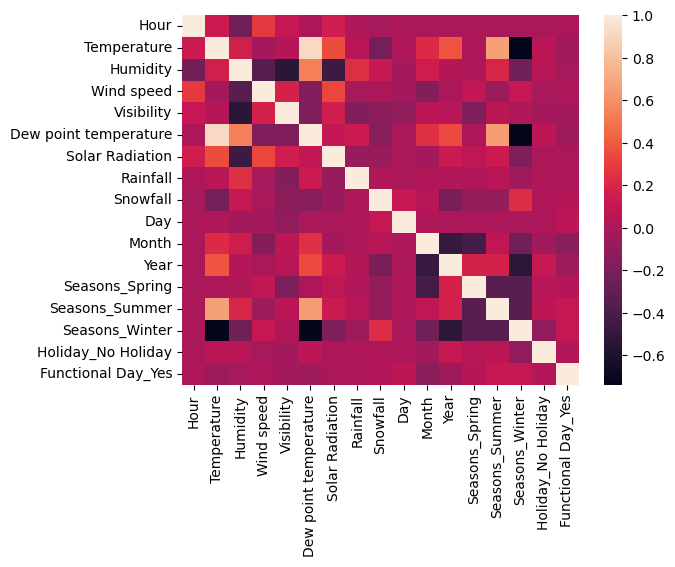

In [146]:
sns.heatmap(X.corr())

<Axes: xlabel='Month', ylabel='Rented Bike Count'>

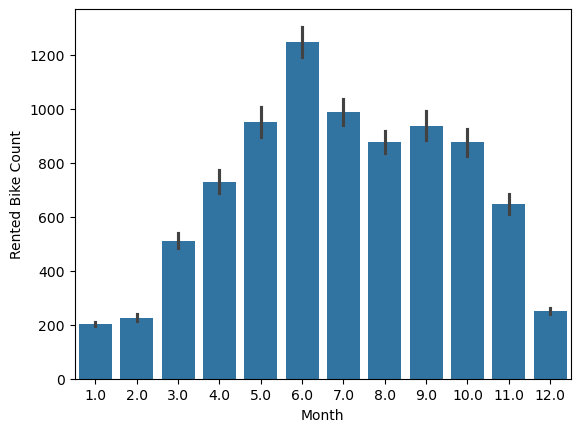

In [147]:
sns.barplot(x='Month', y=y, data=X)

<Axes: xlabel='Day', ylabel='Rented Bike Count'>

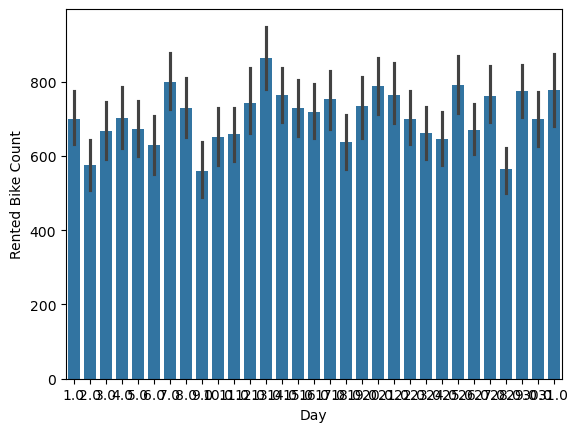

In [148]:
sns.barplot(x="Day", y=y, data=X)

<Axes: xlabel='Rainfall', ylabel='Rented Bike Count'>

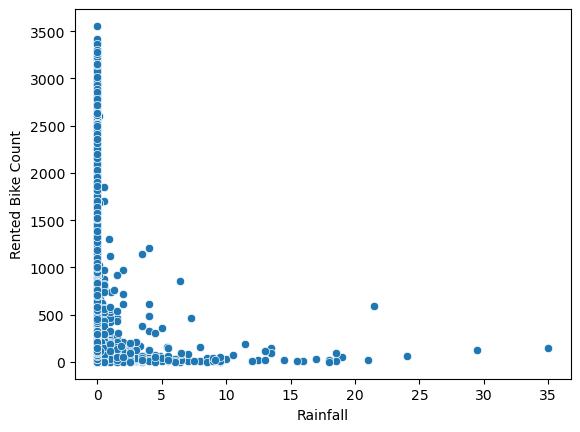

In [149]:
sns.scatterplot(x='Rainfall', y=y, data=X)  

<Axes: xlabel='Snowfall', ylabel='Rented Bike Count'>

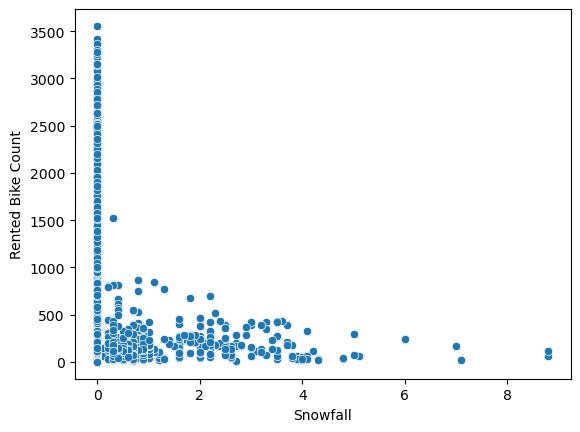

In [150]:
sns.scatterplot(x="Snowfall", y=y, data=X)

<Axes: xlabel='Temperature', ylabel='Rented Bike Count'>

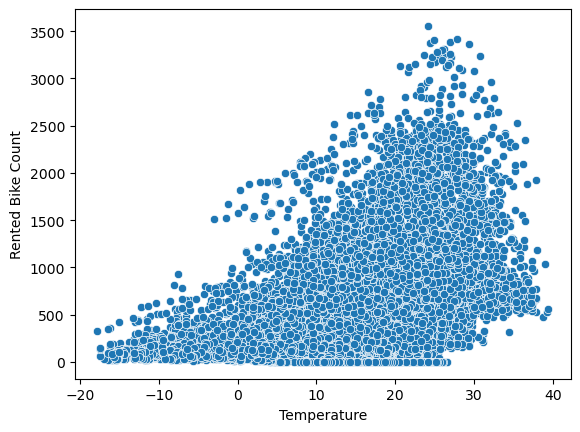

In [151]:
sns.scatterplot(x="Temperature", y=y, data=X)

<Axes: xlabel='Wind speed', ylabel='Rented Bike Count'>

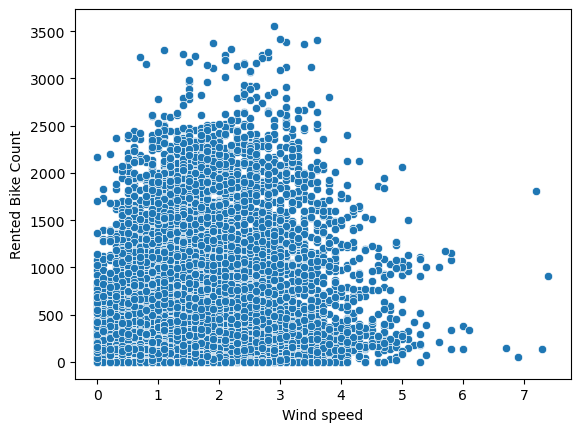

In [152]:
sns.scatterplot(x="Wind speed", y=y, data=X)

In [153]:
lm = sm.OLS(y, X).fit()

print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:      Rented Bike Count   R-squared (uncentered):                   0.795
Model:                            OLS   Adj. R-squared (uncentered):              0.795
Method:                 Least Squares   F-statistic:                              1998.
Date:                Thu, 09 Jan 2025   Prob (F-statistic):                        0.00
Time:                        23:21:39   Log-Likelihood:                         -65594.
No. Observations:                8760   AIC:                                  1.312e+05
Df Residuals:                    8743   BIC:                                  1.313e+05
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

With the p values produced and the large condition number, it is clear we need to perform some form of feature selection. I will use lasso regression to see which variables are most important in the prediction.

In [154]:
lasso = sm.OLS(y, X).fit_regularized(method='elastic_net', alpha=0.1, L1_wt=1)

print("Lasso Regression Coefficients:")
print(lasso.params)

Lasso Regression Coefficients:
Hour                      26.240363
Temperature                9.308941
Humidity                 -11.552014
Wind speed                22.244678
Visibility                 0.031987
Dew point temperature     16.886413
Solar Radiation          -62.493750
Rainfall                 -57.592126
Snowfall                  27.416864
Day                       -0.000368
Month                      7.951308
Year                       0.035022
Seasons_Spring           -60.812330
Seasons_Summer           -93.293391
Seasons_Winter          -309.429074
Holiday_No Holiday       140.319947
Functional Day_Yes       734.396895
dtype: float64


In [155]:
selected = lasso.params[lasso.params > 0.05]
print(selected)

Hour                      26.240363
Temperature                9.308941
Wind speed                22.244678
Dew point temperature     16.886413
Snowfall                  27.416864
Month                      7.951308
Holiday_No Holiday       140.319947
Functional Day_Yes       734.396895
dtype: float64


In [156]:
X = X[selected.index]

smaller_lm = sm.OLS(y, X).fit()

print(smaller_lm.summary())

                                 OLS Regression Results                                
Dep. Variable:      Rented Bike Count   R-squared (uncentered):                   0.748
Model:                            OLS   Adj. R-squared (uncentered):              0.748
Method:                 Least Squares   F-statistic:                              3251.
Date:                Thu, 09 Jan 2025   Prob (F-statistic):                        0.00
Time:                        23:21:40   Log-Likelihood:                         -66499.
No. Observations:                8760   AIC:                                  1.330e+05
Df Residuals:                    8752   BIC:                                  1.331e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

Based on the above results, the month predictor is no longer significant so we remove that as well. This gives us the final linear model below.

In [157]:
X = X.drop(columns=['Month'])

final_lm = sm.OLS(y, X).fit()

print(final_lm.summary())

                                 OLS Regression Results                                
Dep. Variable:      Rented Bike Count   R-squared (uncentered):                   0.748
Model:                            OLS   Adj. R-squared (uncentered):              0.748
Method:                 Least Squares   F-statistic:                              3715.
Date:                Thu, 09 Jan 2025   Prob (F-statistic):                        0.00
Time:                        23:21:40   Log-Likelihood:                         -66500.
No. Observations:                8760   AIC:                                  1.330e+05
Df Residuals:                    8753   BIC:                                  1.331e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------